In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-np.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_mask=None):
        attn_output, _ = self.attention(x, x, x, attn_mask=src_mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_blocks, num_classes, max_len=512, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_blocks)
        ])
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x, src_mask=None):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for block in self.transformer_blocks:
            x = block(x, src_mask)
        x = x.mean(dim=1)  # Global average pooling
        return self.classifier(x)


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset
from torch.nn.utils.rnn import pad_sequence

# Load dataset
dataset = load_dataset("ag_news")

# Tokenizer (simple word-level tokenizer for implementation purposes)
def simple_tokenizer(text, vocab):
    return [vocab.get(token, vocab['<unk>']) for token in text.lower().split()]

# Vocabulary
vocab = {'<pad>': 0, '<unk>': 1}
for text in dataset['train']['text']:
    for token in text.lower().split():
        if token not in vocab:
            vocab[token] = len(vocab)

# Convert dataset to tokenized tensors
def encode_data(data, vocab):
    tokenized_texts = [torch.tensor(simple_tokenizer(text, vocab)) for text in data['text']]
    labels = torch.tensor(data['label'])
    tokenized_texts = pad_sequence(tokenized_texts, batch_first=True, padding_value=vocab['<pad>'])
    return tokenized_texts, labels

train_texts, train_labels = encode_data(dataset['train'], vocab)
test_texts, test_labels = encode_data(dataset['test'], vocab)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
def collate_fn(batch):
    """
    Collate function for DataLoader to handle variable-length sequences.
    """
    inputs = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Pad inputs to the maximum length in the batch
    inputs = pad_sequence(inputs, batch_first=True, padding_value=vocab['<pad>'])

    # Stack targets into a single tensor
    targets = torch.stack(targets)

    return inputs, targets

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
<ipython-input-12-61052b5ab599>:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1: Train Loss = 0.7848, Val Accuracy = 0.8229


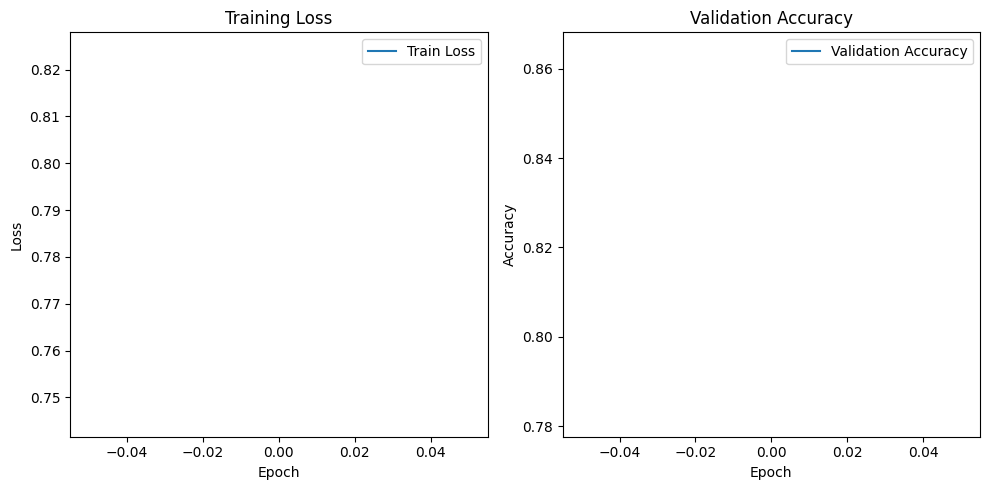

Epoch 2: Train Loss = 0.3694, Val Accuracy = 0.8732


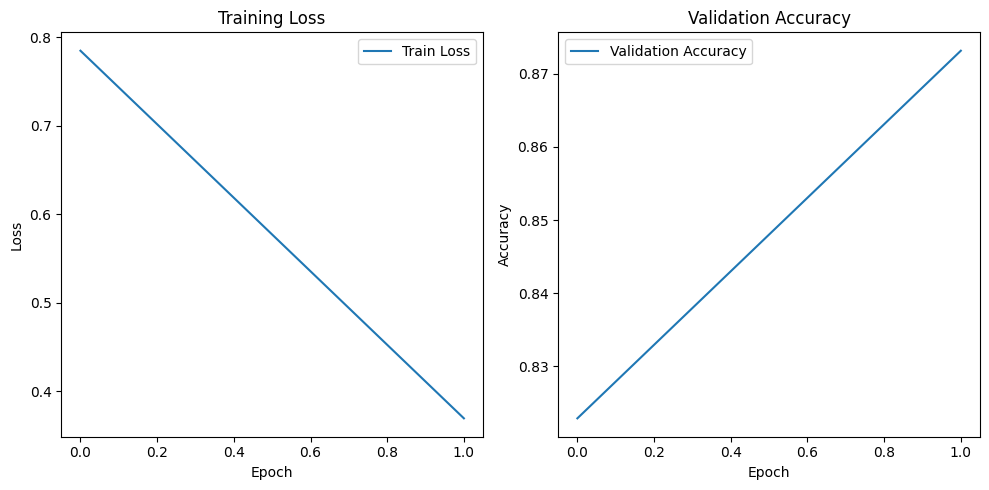

Epoch 3: Train Loss = 0.2838, Val Accuracy = 0.8829


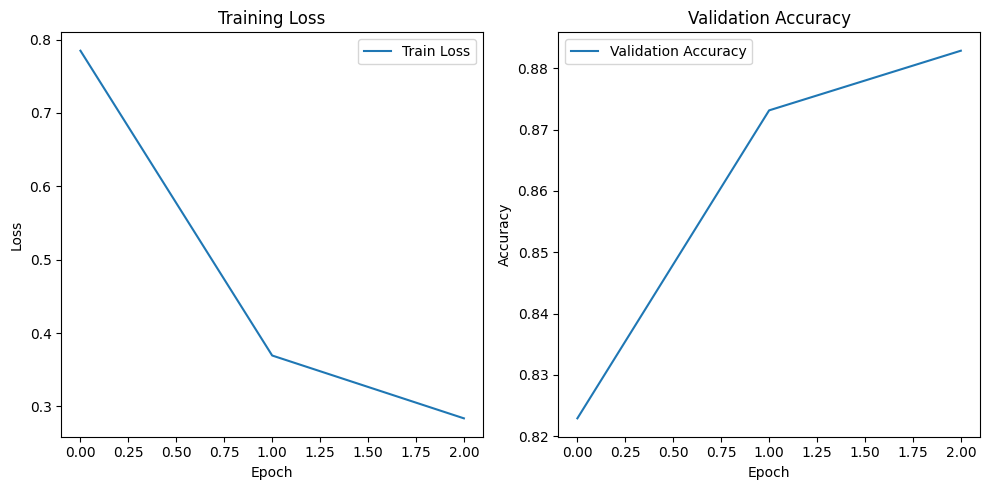

In [ ]:
# Model and hyperparameters
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(
    vocab_size=len(vocab),
    embed_dim=64,        # Smaller embedding size
    num_heads=2,         # Fewer attention heads
    ff_dim=128,          # Smaller feedforward size
    num_blocks=1,        # Fewer transformer blocks
    num_classes=4        # Number of categories
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

model.to(device)


# DataLoader
train_dataset = torch.utils.data.TensorDataset(train_texts, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_texts, test_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)


# For live plotting
import matplotlib.pyplot as plt

train_losses = []
val_accuracies = []

from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
for epoch in range(3):
    # Training loop
    scheduler.step()

    model.train()
    total_loss = 0
    correct, total = 0, 0

    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision training
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # Compute metrics
    train_losses.append(total_loss / len(train_loader))
    train_accuracy = correct / total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}: Train Loss = {train_losses[-1]:.4f}, Val Accuracy = {val_accuracy:.4f}")

    # Live plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


Accuracy: 0.8828947368421053, Precision: 0.8831170399321735, Recall: 0.8828947368421053, F1 Score: 0.88264503803051


In [ ]:
# prompt: try to generate soomething with prompt for above transformer to test its function

prompt = "internet"

# Encode the prompt using the same tokenizer as the model
tokenized_prompt = torch.tensor(simple_tokenizer(prompt, vocab)).unsqueeze(0).to(device)

# Generate predictions for the prompt
with torch.no_grad():
    outputs = model(tokenized_prompt)
    predicted_class = torch.argmax(outputs, dim=1).item()

# Print the predicted class
print(f"The predicted class for the prompt is: {predicted_class}")

The predicted class for the prompt is: 3
